*Getting Started with Tensorflow 2*

*Week 2 Lab*

*Coursera/Imperial College London*

In [1]:
#!pip install tensorflow==2.0

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

### **Validations sets**

**Load the data**

In [3]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [4]:
# Save the input and target variables
#print(diabetes_dataset.keys())

data = diabetes_dataset['data']
targets = diabetes_dataset['target']

In [5]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis=0)) / targets.std()

#targets

In [6]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)

print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


**Train a feedfoward neural network model**

In [7]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
  model = Sequential([
      Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(1)
  ])
  return model

model = get_model()
      

In [8]:
# Print the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [9]:
# Compile the model

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [10]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100,
                    validation_split=0.15, batch_size=64, verbose=False)

In [11]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.9091 - mae: 0.7104


[0.8293033666080899, 0.7103962]

**Plot the learning curves**

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

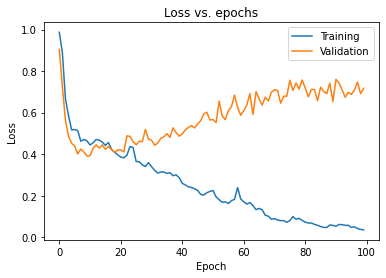

In [13]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

###**Model regularisation**

**Adding regularisation with weight decay and dropout**

In [14]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [15]:
def get_regularised_model(wd, rate):
  model = Sequential([
                      Dense(128, kernel_regularizer=regularizers.l2(wd), activation='relu', input_shape=(train_data.shape[1],)),
                      Dropout(rate),
                      Dense(128, kernel_regularizer=regularizers.l2(wd), activation='relu'),
                      Dropout(rate),
                      Dense(128, kernel_regularizer=regularizers.l2(wd), activation='relu'),
                      Dropout(rate),
                      Dense(128, kernel_regularizer=regularizers.l2(wd), activation='relu'),
                      Dropout(rate),
                      Dense(128, kernel_regularizer=regularizers.l2(wd), activation='relu'),
                      Dropout(rate),
                      Dense(128, kernel_regularizer=regularizers.l2(wd), activation='relu'),
                      Dropout(rate),
                      Dense(1)
                      ])
  return model

If you're familiar with tensorflow one, you should be extra careful here when giving the dropout rate. Because by default in Tensorflow 1, the argument is taken to be the keep probability, or one minus the dropout rate that we are using here.

In [16]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5, 0.3)

In [17]:
# Compile the model
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [18]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100, 
                    validation_split=0.15, batch_size=64, verbose=False)

In [19]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.6244 - mae: 0.6054


[0.6116993519994948, 0.6054453]

**Plot the learning curves**

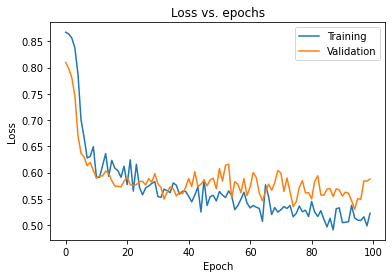

In [20]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

###**Introduction to Callbacks**

**Example training callback**

In [21]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):

  def on_train_begin(self, logs=None):
    print("Starting training...")

  def on_epoch_begin(self, epoch, logs=None):
    print(f"Starting epoch {epoch}")

  def on_train_batch_begin(self, batch, logs=None):
    print(f"Training: Starting batch {batch}")
  
  def on_train_batch_end(self, batch, logs=None):
    print(f"Training: Finished batch {batch}")
  
  def on_epoch_end(self, epoch, logs=None):
    print(f"Finished epoch {epoch}")
  
  def on_train_end(self, logs=None):
    print("Finished training:")

In [22]:
# Re-build the model

model = get_regularised_model(1e-5, 0.3)

In [23]:
# Compile the model 

model.compile(optimizer="adam", loss="mae")

**Train the model with the callback**

In [24]:
# Train the model, with some of the data reserved for validation

model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose=False, callbacks=[TrainingCallback()])

Starting training...
Starting epoch 0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 0
Starting epoch 1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 1
Starting epoch 2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 2
Finished training:


In [25]:
class TestingCallback(Callback):

  def on_test_begin(self, logs=None):
    print("Starting testing...")

  def on_test_batch_begin(self, batch, logs=None):
    print(f"Testing: Starting batch {batch}")
  
  def on_test_batch_end(self, batch, logs=None):
    print(f"Testing: Finished batch {batch}")
  
  def on_test_end(self, logs=None):
    print("Finished testing:")

In [26]:
# Evaluate the model

model.evaluate(test_data, test_targets, verbose=False, callbacks=[TestingCallback()])

Starting testing...
Testing: Starting batch 0
Testing: Finished batch 0
Testing: Starting batch 1
Testing: Finished batch 1
Finished testing:


0.8164519389470418

In [27]:
class PredictionCallback(Callback):

  def on_predict_begin(self, logs=None):
    print("Starting prediction...")

  def on_predict_batch_begin(self, batch, logs=None):
    print(f"Prediction: Starting batch {batch}")
  
  def on_predict_batch_end(self, batch, logs=None):
    print(f"Prediction: Finished batch {batch}")
  
  def on_predict_end(self, logs=None):
    print("Finished prediction:")

In [28]:
# Make predictions with the model

model.predict(test_data, verbose=False, callbacks=[PredictionCallback()])

Starting prediction...
Prediction: Starting batch 0
Prediction: Finished batch 0
Prediction: Starting batch 1
Prediction: Finished batch 1
Finished prediction:


array([[-0.1569641 ],
       [-0.14449295],
       [-0.16686746],
       [-0.16361703],
       [-0.08649811],
       [-0.17609194],
       [-0.18141685],
       [-0.16253802],
       [-0.10827801],
       [-0.09149125],
       [-0.09595225],
       [-0.1707513 ],
       [-0.1290118 ],
       [-0.12450729],
       [-0.18982963],
       [-0.10286193],
       [-0.10726932],
       [-0.19929093],
       [-0.09631908],
       [-0.20286584],
       [-0.20275003],
       [-0.1569543 ],
       [-0.11869434],
       [-0.1597741 ],
       [-0.09556255],
       [-0.20887521],
       [-0.17957227],
       [-0.1951263 ],
       [-0.17451024],
       [-0.11569791],
       [-0.14137541],
       [-0.12229139],
       [-0.06776708],
       [-0.10261365],
       [-0.17172217],
       [-0.07658674],
       [-0.08843324],
       [-0.0696481 ],
       [-0.13523404],
       [-0.08493643],
       [-0.0774026 ],
       [-0.10538361],
       [-0.13322428],
       [-0.12681542],
       [-0.1977396 ]], dtype=flo

###**Early stopping / patience**

**Re-train the models with early stopping**

In [29]:
# Re-train the unregularised model

unregularised_model = get_model()
unregularised_model.compile(optimizer='adam', loss='mse')
unreg_history = unregularised_model.fit(train_data, 
                                        train_targets, 
                                        epochs=100,
                                        validation_split=0.15, 
                                        batch_size=64, 
                                        verbose=False, 
                                        callbacks=[tf.keras.callbacks.EarlyStopping()])

In [30]:
# Evaluate the mdoel on the test set

unregularised_model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.5251


0.6068576508098178

In [31]:
# Re-train the unregularised_model

regularised_model = get_regularised_model(1e-8, 0.2)
regularised_model.compile(optimizer='adam', loss='mse')
reg_history = regularised_model.fit(train_data, 
                                    train_targets, 
                                    epochs=100,
                                    validation_split=0.15, 
                                    batch_size=64,
                                    verbose=False,
                                    callbacks=[tf.keras.callbacks.EarlyStopping()])

In [32]:
# Evaluate the model on the test set

regularised_model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.4925


0.5424834701750013

**Plot the learning curves**

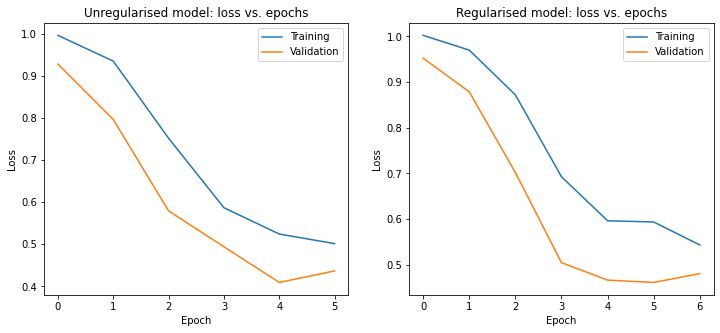

In [33]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()